A more general ctivity list extracted from https://www.health.harvard.edu/diet-and-weight-loss/calories-burned-in-30-minutes-of-leisure-and-routine-activities

## Step 0. import package

In [338]:
import requests
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup  

## Step 1. grab data from web page

In [167]:
def check_link(url):
    try:
        r = requests.get(url)
        r.raise_for_status()
        r.encoding = r.apparent_encoding
        return r.text
    except:
        print('page not found')

def get_contents(ulist,rurl):
    soup = BeautifulSoup(rurl,'lxml')
    trs = soup.find_all('tr')
    for tr in trs:
        ui = []
        for td in tr:
            ui.append(td.string)
        ulist.append(ui)

In [147]:
def save_contents(urlist):
    try:
        with open('activity.csv','w') as f:
            writer = csv.writer(f)
            #writer.writerow(['activity list'])
            for i in range(6,len(urlist)):
                writer.writerow([urlist[i][1],urlist[i][3],urlist[i][5],urlist[i][7]])
    except:
        pass

def main():
    urli = []
    url = 'https://www.health.harvard.edu/diet-and-weight-loss/calories-burned-in-30-minutes-of-leisure-and-routine-activities'
    rs = check_link(url)
    get_contents(urli,rs)
    save_contents(urli)

main()

## Step 2. transfer csv file to pandas dataframe

In [314]:
df = pd.read_csv('activity.csv',names=['activity_name','125-pound person','155-pound person','185-pound person'])
print(df.shape)
df.head()

(169, 4)


,activity_name,125-pound person,155-pound person,185-pound person
0,Gym Activities,125-pound person,155-pound person,185-pound person
1,Weight Lifting: general,90,112,133
2,Aerobics: water,120,149,178
3,"Stretching, Hatha Yoga",120,149,178
4,Calisthenics: moderate,135,167,200


## Step 3. basic exploration

### 1. drop empty rows

In [315]:
drop_lst = []
for i in range(len(df)):
    if df.iloc[i][0] == ' ':
        drop_lst.append(i)
df = df.drop(df.index[drop_lst])
df = df.reset_index(drop=True)
print(df.shape)
df.head()

(164, 4)


,activity_name,125-pound person,155-pound person,185-pound person
0,Gym Activities,125-pound person,155-pound person,185-pound person
1,Weight Lifting: general,90,112,133
2,Aerobics: water,120,149,178
3,"Stretching, Hatha Yoga",120,149,178
4,Calisthenics: moderate,135,167,200


### 2. add group information

__1) add group_name: large categories__

In [316]:
index_lst = []
group_lst = []
for i in range(len(df)):
    if i == 0 or df.iloc[i][1] == ' ':
        index_lst.append(i)
        group_lst.append(df.iloc[i][0])
print(index_lst, group_lst)

group = []
index_lst += [len(df)]
for i in range(len(index_lst)-1):
    group += [group_lst[i] for j in range(index_lst[i+1]-index_lst[i])]
df['group_name'] = group
df = df.drop(df.index[index_lst[:-1]])

[0, 21, 100, 115, 130, 141] ['Gym Activities', 'Training and Sport Activities', 'Outdoor Activities', 'Home & Daily Life Activities', 'Home Repair', 'Occupational Activities']


In [320]:
df = df[['group_name','activity_name','125-pound person','155-pound person','185-pound person']].reset_index(drop=True)
df[['125-pound person','155-pound person','185-pound person']] = df[['125-pound person','155-pound person','185-pound person']].astype('float')
df.head()

,group_name,activity_name,125-pound person,155-pound person,185-pound person
0,Gym Activities,Weight Lifting: general,90.0,112.0,133.0
1,Gym Activities,Aerobics: water,120.0,149.0,178.0
2,Gym Activities,"Stretching, Hatha Yoga",120.0,149.0,178.0
3,Gym Activities,Calisthenics: moderate,135.0,167.0,200.0
4,Gym Activities,Riders: general,150.0,186.0,222.0


__2) add subgroup_name: small categories__

In [321]:
subgroup_name = []
for i in range(len(df)):
    subgroup_name.append(df['activity_name'][i].split(':')[0].split(',')[0])
df['subgroup_name'] = subgroup_name
df = df[['group_name','subgroup_name','activity_name','125-pound person','155-pound person','185-pound person']]
df = df.sort_values(by=['group_name','subgroup_name']).reset_index(drop=True)
df.head()

,group_name,subgroup_name,activity_name,125-pound person,155-pound person,185-pound person
0,Gym Activities,Aerobics,Aerobics: water,120.0,149.0,178.0
1,Gym Activities,Aerobics,Aerobics: low impact,165.0,205.0,244.0
2,Gym Activities,Aerobics,"Aerobics, Step: low impact",210.0,260.0,311.0
3,Gym Activities,Aerobics,Aerobics: high impact,210.0,260.0,311.0
4,Gym Activities,Aerobics,"Aerobics, Step: high impact",300.0,372.0,444.0


__3) dataframe info__

In [322]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 6 columns):
group_name          158 non-null object
subgroup_name       158 non-null object
activity_name       158 non-null object
125-pound person    158 non-null float64
155-pound person    158 non-null float64
185-pound person    158 non-null float64
dtypes: float64(3), object(3)
memory usage: 7.5+ KB


### 3. group analysis

__1) frequency__

In [357]:
freq = df.groupby('group_name').size().sort_values(ascending=False)
freq

group_name
Training and Sport Activities    78
Occupational Activities          22
Gym Activities                   20
Outdoor Activities               14
Home & Daily Life Activities     14
Home Repair                      10
dtype: int64

__2) mean value of big categories__

In [326]:
means = df[['125-pound person','155-pound person','185-pound person']].groupby(df['group_name']).mean()
means.sort_values(by=['155-pound person'],ascending=False)

,125-pound person,155-pound person,185-pound person
group_name,,,
Training and Sport Activities,219.807692,272.589744,325.294872
Gym Activities,203.250000,252.000000,300.800000
Outdoor Activities,143.857143,178.285714,212.928571
Home Repair,139.500000,172.900000,206.400000
Occupational Activities,130.272727,161.500000,192.727273
Home & Daily Life Activities,103.500000,128.142857,153.000000


__3) mean value of small categories__

- take the first ten intensive activities as an example

In [328]:
means_sub = df[['125-pound person','155-pound person','185-pound person']].groupby(df['subgroup_name']).mean()
means_sub.sort_values(by=['155-pound person'],ascending=False)[:10]

,125-pound person,155-pound person,185-pound person
subgroup_name,,,
Firefighting,360.000000,446.000000,533.000000
Handball,360.000000,446.000000,533.000000
Running,328.333333,407.222222,486.000000
Bicycling,310.714286,385.285714,459.857143
Martial Arts,300.000000,372.000000,444.000000
Water Polo,300.000000,372.000000,444.000000
Rope Jumping,300.000000,372.000000,444.000000
Rock Climbing,285.000000,353.500000,421.500000
Ski Machine,285.000000,353.000000,422.000000


__4) group stats__

In [348]:
df.groupby(['group_name','subgroup_name']).describe()

125-pound person  \
                                                                   count   
group_name                    subgroup_name                                
Gym Activities                Aerobics                               5.0   
                              Bicycling                              2.0   
                              Calisthenics                           2.0   
                              Circuit Training                       1.0   
                              Elliptical Trainer                     1.0   
                              Riders                                 1.0   
                              Rowing                                 2.0   
                              Ski Machine                            1.0   
                              Stair Step Machine                     1.0   
                              Stretching                             1.0   
                              Teaching aerobics                      1.0   
                              Weight Lifting                         2.0   
Home & Daily Life Activities  Child games                            1.0   
                              Child-care                             1.0   
                              Cooking                                1.0   
                              Food Shopping                          1.0   
                              Heavy Cleaning                         1.0   
                              Moving                                 3.0   
                              Playing w/kids                         2.0   
                              Reading                                1.0   
                              Sleeping                               1.0   
                              Standing in line                       1.0   
                              Watching TV                            1.0   
Home Repair                   Auto Repair                            1.0   
                              Carpentry                              2.0   
                              Cleaning rain gutters                  1.0   
                              Hanging storm windows                  1.0   
                              Lay or remove carpet/tile              1.0   
                              Paint                                  1.0   
                              Paint house                            1.0   
...                                                                  ...   
Training and Sport Activities Horseback Riding                       1.0   
                              Ice Skating                            1.0   
                              Kayaking                               1.0   
                              Martial Arts                           1.0   
                              Orienteering                           1.0   
                              Race Walking                           1.0   
                              Racquetball                            2.0   
                              Rock Climbing                          2.0   
                              Rollerblade Skating                    1.0   
                              Rope Jumping                           1.0   
                              Running                                9.0   
                              Scuba or skin diving                   1.0   
                              Skateboarding                          1.0   
                              Skiing                                 2.0   
                              Sledding                               1.0   
                              Snorkeling                             1.0   
                              Snow Shoeing                           1.0   
                              Soccer                                 1.0   
                              Softball                               1.0   
                            

- take 'Gym Acitivities' category and '155-pound person' column as an example

In [354]:
gym_df = df.loc[df['group_name']=='Gym Activities']
gym_df.groupby(['group_name','subgroup_name'],as_index=False).agg(['mean','max','median','count'])['155-pound person']

mean    max  median  count
group_name     subgroup_name                                  
Gym Activities Aerobics            249.2  372.0   260.0      5
               Bicycling           325.5  391.0   325.5      2
               Calisthenics        232.5  298.0   232.5      2
               Circuit Training    298.0  298.0   298.0      1
               Elliptical Trainer  335.0  335.0   335.0      1
               Riders              186.0  186.0   186.0      1
               Rowing              288.0  316.0   288.0      2
               Ski Machine         353.0  353.0   353.0      1
               Stair Step Machine  223.0  223.0   223.0      1
               Stretching          149.0  149.0   149.0      1
               Teaching aerobics   223.0  223.0   223.0      1
               Weight Lifting      167.5  223.0   167.5      2

## Step 4. basic visualization

### 1. calories distribution in whole dataset

In [400]:
def dist_plot(data,xlabel,ylabel,title,name):
    plt.close('all')
    fig = plt.figure(figsize=(7,5))
    sns.distplot(data,color='skyblue')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    sns.despine()
    plt.savefig(name,bbox_inches='tight')
    plt.show()

/Users/ice/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


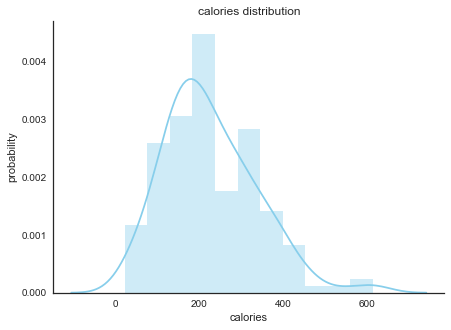

In [402]:
dist_plot(df['155-pound person'],'calories','probability','calories distribution','act_calory_dist.png')

### 2. calories mean value of each group

/Users/ice/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


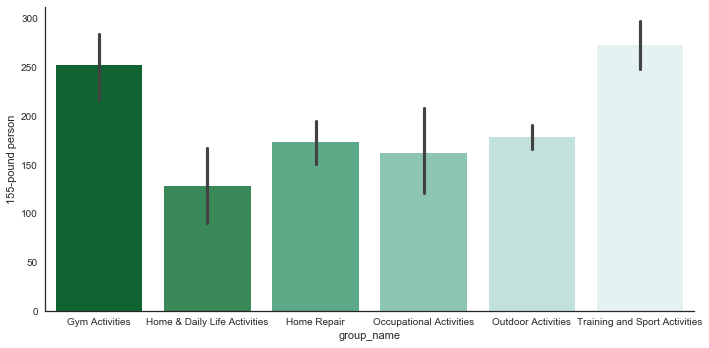

In [403]:
plt.close('all')
sns.set(style="white")
sns.factorplot(data=df, x="group_name", y="155-pound person",kind="bar",palette="BuGn_r", size=5, aspect=2)
plt.savefig('act_calory_mean.png',bbox_inches='tight')
plt.show()

### 3. frequency of each group

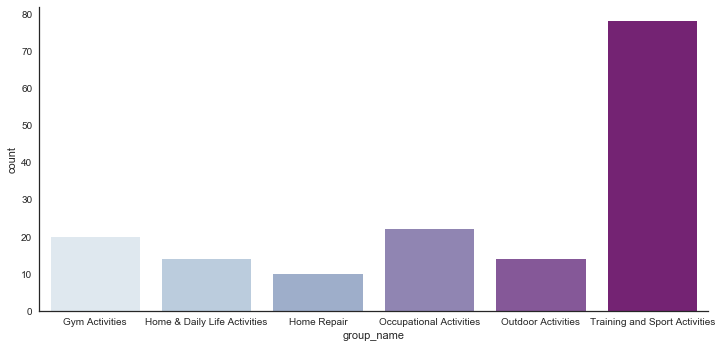

In [404]:
plt.close('all')
sns.set(style="white")
sns.factorplot(data=df, x="group_name", kind="count",palette="BuPu", size=5, aspect=2)
plt.savefig('act_group_freq.png',bbox_inches='tight')
plt.show()